In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import bilby
import pycbc
import pickle
import deepdish
import pycbc.psd
import pycbc.types
import gwpopulation
import pycbc.waveform 
import numpy as np
import scipy as sp
import pandas as pd
from glob import glob
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys 
sys.path.append('../../src/scripts/match_final/')
import waveforms as wf
gen = wf.PairsWaveformGeneration()

import lalsimulation

import pycbc.waveform as waveform
from pycbc.waveform.utils import taper_timeseries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [22]:
def new_rcParams(width='column'):
    
    scale_factor = 2.125

    if width == 'column':
        fig_width_pt = scale_factor*246.0
        fs = scale_factor*7.96
        aspect_ratio=(1 + 5 ** 0.5) / 2
    elif width == 'page':
        fig_width_pt = scale_factor*510.0
        fs = scale_factor*9
        aspect_ratio=2.75
    inches_per_pt = 1.0/72.27

    fig_width = fig_width_pt*inches_per_pt
    fig_height = fig_width/aspect_ratio

    figsize = (fig_width, fig_height)

    new_params = {}
    new_params['figure.figsize'] = figsize
    new_params['font.size'] = fs
    new_params['text.usetex'] = True
    new_params['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}'
    new_params['axes.labelsize'] = 'medium'
    new_params['font.serif'] = 'times'
    new_params['font.family'] = 'serif'
    new_params['mathtext.fontset'] = 'stix'
    new_params['xtick.direction'] = 'in'
    new_params['ytick.direction'] = 'in'
    new_params['xtick.minor.visible'] = True
    new_params['ytick.minor.visible'] = True
    new_params['legend.fontsize'] = 'medium'
    new_params['legend.handlelength'] = 1.5
    
    return new_params

color_palette = {
    'primary': '#0072B2',
    'secondary':  '#CC79A7',
    'tertiary': '#009E73',
    'color3'    : '#D55E00',
    'color4'    : '#56B4E9',
    'color5'    : '#40B0A6',
    'color6'    : '#E69F00',
    'color7'    : '#DC3220',
    'LLO': '#3953a4',
    'LHO': '#ed2024',
    'colormap': 'viridis'
}

import matplotlib.pyplot as plt
plt.rcParams.update(new_rcParams())

In [3]:
delta_f = 1
duration = 4
f_lower = 20
f_ref = 50
f_higher = 1024
sampling_frequency = 2048.0
delta_t = 1/sampling_frequency
kwargs = dict(sampling_frequency=sampling_frequency, f_lower=f_lower, f_ref=f_ref, delta_t=delta_t)
duration = 4.0

In [4]:
waveform_params_a = np.load('../../src/data/waveform_params_a.npy', allow_pickle=True).item()
waveform_params_b = np.load('../../src/data/waveform_params_b.npy', allow_pickle=True).item()

In [5]:
mchirpratio, snrratio = [.5, 1., 2.], [.5, 1.]
delta_tc = [-.1, -.05, -.03, -.02, -.01, .01, .02, .03, .05, .1]

combinations = list(itertools.product(mchirpratio, snrratio, delta_tc))

data_a, data_b = [], []
mchirp_a, mchirp_b = np.zeros(len(combinations)), np.zeros(len(combinations))
q_a, q_b = np.zeros(len(combinations)), np.zeros(len(combinations))
eta_a, eta_b = np.zeros(len(combinations)), np.zeros(len(combinations))
eff_spin_a, eff_spin_b = np.zeros(len(combinations)), np.zeros(len(combinations))
delta_tc, snr_a, snr_b = np.zeros(len(combinations)), np.zeros(len(combinations)), np.zeros(len(combinations))

for i in range(len(combinations)):
    data_a.append(np.load('../../src/output/pe_population/injections/SINGLES_A_{}_{}_{}.npy'.format(combinations[i][0], combinations[i][1], combinations[i][2]), allow_pickle=True).item())
    data_b.append(np.load('../../src/output/pe_population/injections/SINGLES_B_{}_{}_{}.npy'.format(combinations[i][0], combinations[i][1], combinations[i][2]), allow_pickle=True).item())

    mchirp_a[i], mchirp_b[i] = np.power(data_a[i]['mass_1']*data_a[i]['mass_2'], (3/5))/np.power(data_a[i]['mass_1']+data_a[i]['mass_2'], (1/5)), np.power(data_b[i]['mass_1']*data_b[i]['mass_2'], (3/5))/np.power(data_b[i]['mass_1']+data_b[i]['mass_2'], (1/5))
    q_a[i], q_b[i] = data_a[i]['mass_2']/data_a[i]['mass_1'], data_b[i]['mass_2']/data_b[i]['mass_1']
    eta_a[i], eta_b[i] = (data_a[i]['mass_1']*data_a[i]['mass_2'])/np.power(data_a[i]['mass_1']+data_a[i]['mass_2'], 2), (data_b[i]['mass_1']*data_b[i]['mass_2'])/np.power(data_b[i]['mass_1']+data_b[i]['mass_2'], 2)
    eff_spin_a[i], eff_spin_b[i] = data_a[i]['a_1'], data_b[i]['a_1']

    delta_tc[i] = data_b[i]['geocent_time'] - data_a[i]['geocent_time']
    snr_a[i], snr_b[i] = data_a[i]['snr_det'], data_b[i]['snr_det']

In [6]:
i = 26
fs_pe = glob('../../src/output/pe_population/final_result/PE_1.0_0.5_0.02/*')
fs_pe_ml = glob('../../src/output/pe_population/final_result/PE_ML_1.0_0.5_0.02/*')
fs_pe_ml2 = glob('../../src/output/pe_population/final_result/PE_ML2_1.0_0.5_0.02/*')

result_pe = bilby.result.read_in_result(filename=fs_pe[0])
result_pe_ml = bilby.result.read_in_result(filename=fs_pe_ml[0])
result_pe_ml2 = bilby.result.read_in_result(filename=fs_pe_ml2[0])

17:01 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
17:01 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
17:01 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
17:01 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
17:01 bilby INFO    : Global meta data was removed from the result object for compatibility. Use t

In [7]:
waveform_params_c = waveform_params_b.copy()
waveform_params_c['mass_1'] = waveform_params_a['mass_1']*combinations[i][0]
waveform_params_c['mass_2'] = waveform_params_a['mass_2']*combinations[i][0]
waveform_params_c['geocent_time'] = waveform_params_a['geocent_time'] + combinations[i][2]
start_time = waveform_params_c['geocent_time']-duration+2

In [ ]:
ht = gen.pairs_td(waveform_params_a, waveform_params_c, **kwargs)
recovered_params = {}
for key in waveform_params_a.keys():
    try:
        id = np.argmax(result_pe.posterior.log_likelihood)
        recovered_params[key] = result_pe.posterior[key][id]
    except:
        continue
ht_recovered = gen.wf_td(injection_parameters = recovered_params, **kwargs)
recovered_params_ml = {}
for key in waveform_params_a.keys():
    try:
        id = np.argmax(result_pe_ml.posterior.log_likelihood)
        recovered_params_ml[key] = result_pe_ml.posterior[key][id]
    except:
        continue
    id = np.argmax(result_pe_ml.posterior.log_likelihood)
    recovered_params_ml['luminosity_distance'] = waveform_params_a['luminosity_distance']
    recovered_params_ml['Mlz'] = 10**result_pe_ml.posterior['Log_Mlz'][id]
    recovered_params_ml['y'] = result_pe_ml.posterior['yl'][id]
hf_recovered_ml = gen.wf_ml_fd(injection_parameters = recovered_params_ml, Ml_z=recovered_params_ml['Mlz'],  y=recovered_params_ml['y'], **kwargs)
ht_recovered_ml = hf_recovered_ml['H1'].to_timeseries()
recovered_params_ml2 = {}
for key in waveform_params_a.keys():
    try:
        id = np.argmax(result_pe_ml2.posterior.log_likelihood)
        recovered_params_ml2[key] = result_pe_ml2.posterior[key][id]
    except:
        continue
    recovered_params_ml2['luminosity_distance'] = waveform_params_a['luminosity_distance']
hf_recovered_ml2 = gen.wf_sl_fd(injection_parameters = recovered_params_ml2, imagetype=2, **kwargs)
ht_recovered_ml2 = hf_recovered_ml2['H1'].to_timeseries()
start_time = float(ht['H1'].start_time)

In [19]:
ht['H1'].start_time = start_time + ht['H1'].sample_times[np.argmax(ht_recovered['H1'])] - ht['H1'].sample_times[np.argmax(ht['H1'])]
ht_recovered['H1'].start_time = start_time
ht_recovered_ml.start_time = start_time
ht_recovered_ml2.start_time = start_time

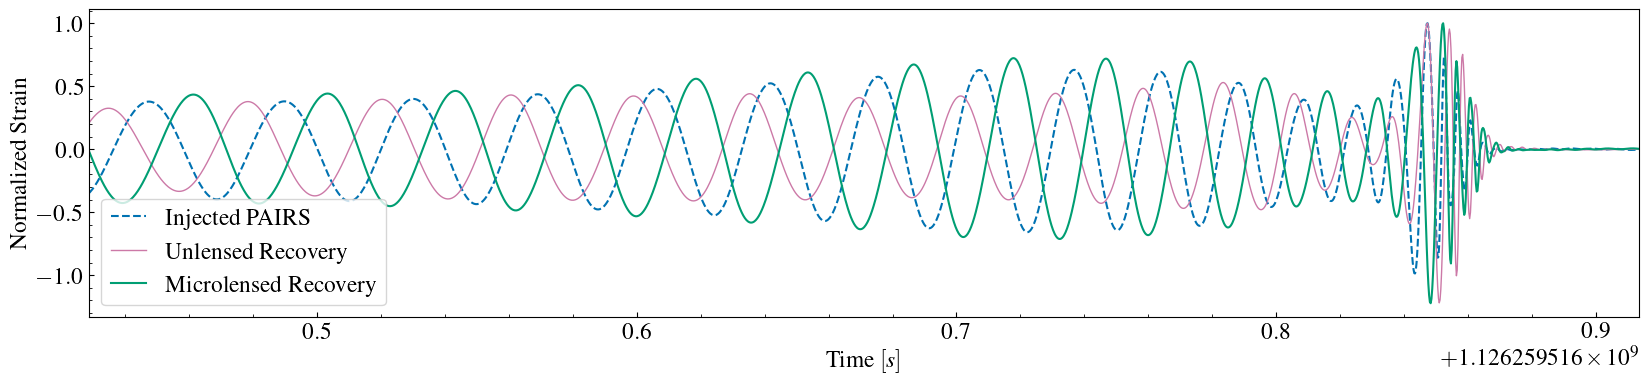

In [23]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(ht['H1'].sample_times, ht['H1']/max(ht['H1']), '--', color=color_palette['primary'], label='Injected $\\rm{PAIRS}$')
ax.plot(ht_recovered['H1'].sample_times, ht_recovered['H1']/max(ht_recovered['H1']), color=color_palette['secondary'], linewidth=1, label='Unlensed Recovery')
ax.plot(ht_recovered_ml2.sample_times, ht_recovered_ml2/max(ht_recovered_ml2), color=color_palette['tertiary'], linewidth=1.5, label='Microlensed Recovery')
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Normalized Strain')
duration=4
ax.set_xlim(start_time+56, start_time+56.485)
ax.legend(loc='lower left')
plt.savefig('../../plots/MicrolensedOverlappedSignals.pdf', dpi=600, bbox_inches='tight')
plt.show()

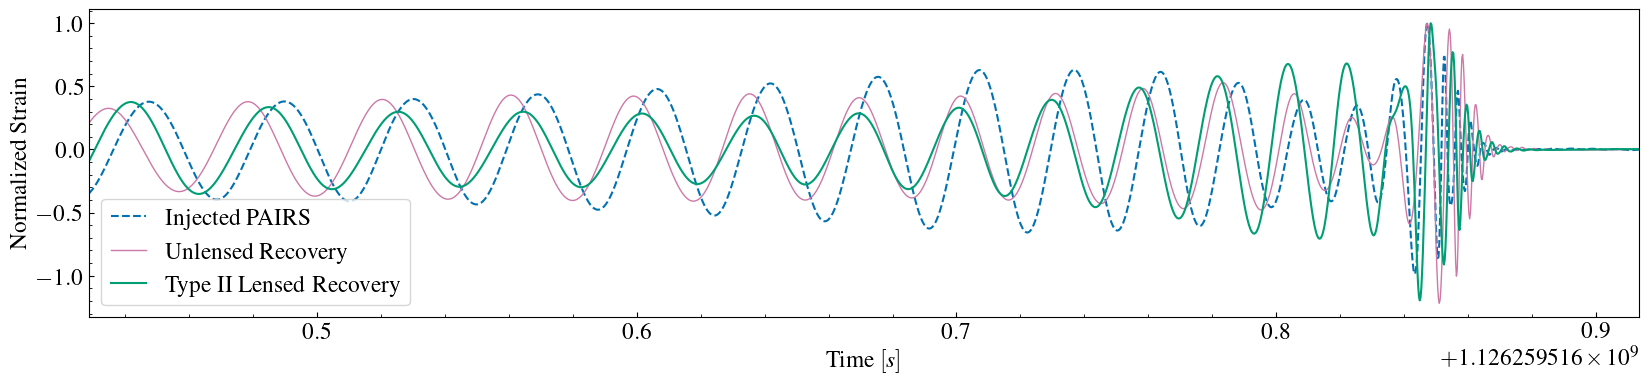

In [24]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(ht['H1'].sample_times, ht['H1']/max(ht['H1']), '--', color=color_palette['primary'], label='Injected $\\rm{PAIRS}$')
ax.plot(ht_recovered['H1'].sample_times, ht_recovered['H1']/max(ht_recovered['H1']), color=color_palette['secondary'], linewidth=1, label='Unlensed Recovery')
ax.plot(ht_recovered_ml.sample_times, ht_recovered_ml/max(ht_recovered_ml), color=color_palette['tertiary'], linewidth=1.5, label='Type II Lensed Recovery')
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Normalized Strain')
ax.set_xlim(start_time+56, start_time+56.485)
ax.legend(loc='lower left')
plt.savefig('../../plots/TypeIILensedOverlappedSignals.pdf', dpi=600, bbox_inches='tight')
plt.show()